<a href="https://colab.research.google.com/github/takehiro161013/kaggle_homecredit/blob/main/Home_Credit_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries and datas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2021_Summer/competition2/input/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2021_Summer/competition2/input/test.csv', index_col=0)
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2021_Summer/competition2/input/sample_submission.csv', index_col=0)

In [ ]:
print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (171202, 50)
Test size: (61500, 49)


In [ ]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(train.shape[0], train.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(test.shape[0], test.shape[1]))

訓練データのデータ数は171202、変数は50種類です。
テストデータのデータ数は61500、変数は49種類です


In [ ]:
train.head(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0
5,1,Cash loans,F,N,Y,0,135000.0,247500.0,19971.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018209,-16795,-425,-2796.0,-324,NaN,1,1,0,1,0,0,Cleaning staff,2.0,3,3,0,0,0,0,0,0,Transport: type 4,NaN,0.552871,NaN,0.0,0.0,0.0,0.0,-307.0,NaN,NaN,NaN,NaN
6,0,Cash loans,F,N,Y,0,189000.0,332946.0,17127.0,238500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.011657,-14519,-4089,-8110.0,-5499,NaN,1,1,0,1,0,0,Cooking staff,2.0,1,1,0,1,1,0,0,0,Trade: type 3,NaN,0.658005,0.399676,6.0,0.0,6.0,0.0,-1918.0,0.0,0.0,0.0,3.0
7,1,Cash loans,M,N,Y,0,157500.0,203760.0,24309.0,180000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.006671,-8624,-379,-1793.0,-1192,NaN,1,1,0,1,0,0,NaN,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,NaN,0.287687,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,0,Cash loans,M,Y,N,1,324000.0,808650.0,22234.5,675000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010643,-14614,-612,-5137.0,-4040,1.0,1,1,0,1,0,0,Managers,3.0,2,2,0,0,0,0,1,1,Military,NaN,0.707878,0.629674,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [ ]:
print('TARGET==1: {:.2f}%'.format(train.TARGET.sum()/train.shape[0]*100))

TARGET==1: 8.07%


In [ ]:
categorical_cols = [col for col in train.columns if train[col].dtype=='object']
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
print(f'Length of categorical columns: {len(categorical_cols)}')
print(f'Length of numerical columns: {len(numerical_cols)}')

Length of categorical columns: 11
Length of numerical columns: 39


In [ ]:
categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE']

In [ ]:
numerical_cols

['TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

## Missing values

In [ ]:
def show_missing(df):
    missing_list = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
    missing_list = missing_list[missing_list>0]

    plt.subplots(figsize=(12, 6))
    plt.xticks(rotation=90)
    sns.barplot(missing_list.index, missing_list.values)

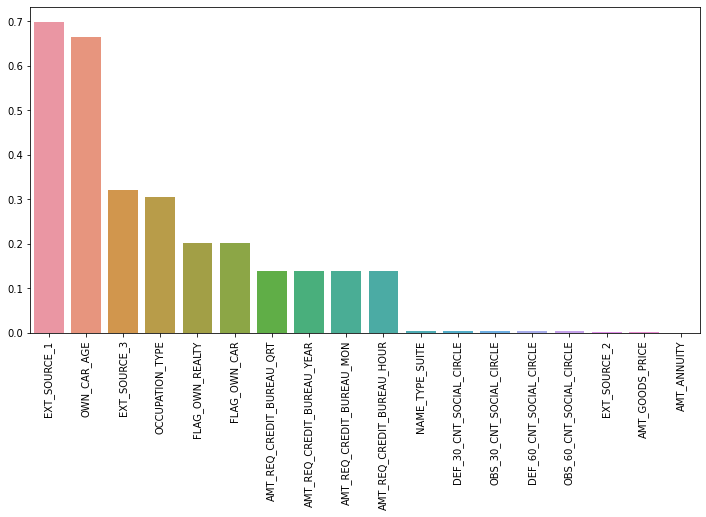

In [ ]:
show_missing(test)

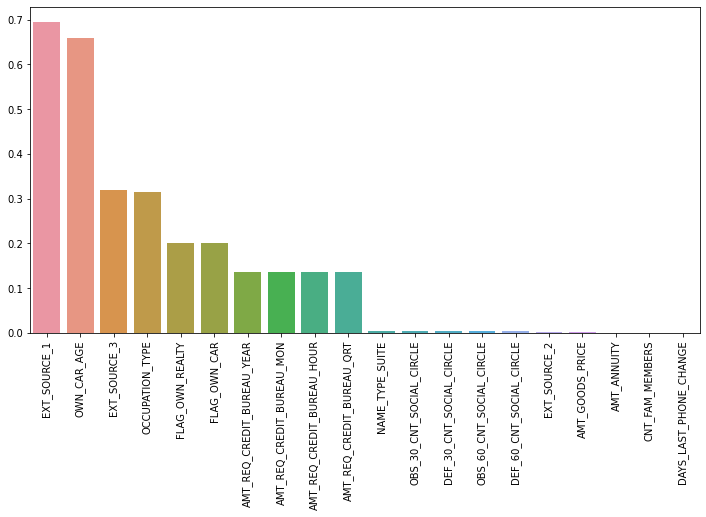

In [ ]:
show_missing(train)

## Correlation matrix

In [ ]:
def show_corrmat(df):
    corrmat = df.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)

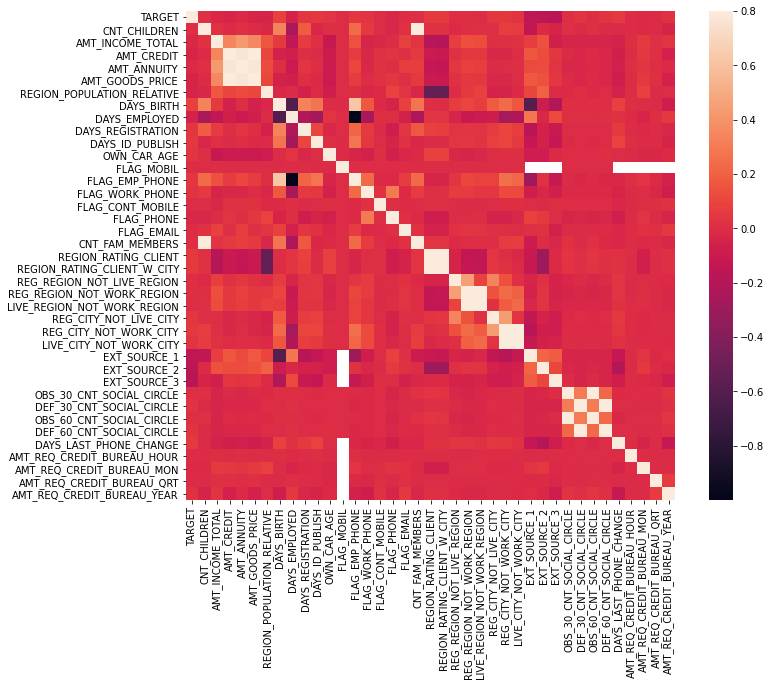

In [ ]:
show_corrmat(train)

### Datas strongly correlated with TARGET

In [ ]:
k = 6
corr_data = pd.concat([train.corr().nlargest(k, 'DAYS_BIRTH')['DAYS_BIRTH'], train.corr().nsmallest(k, 'DAYS_BIRTH')['DAYS_BIRTH']]).sort_values(ascending=False)
corr_data

DAYS_BIRTH                    1.000000
FLAG_EMP_PHONE                0.619834
CNT_CHILDREN                  0.331465
DAYS_REGISTRATION             0.331101
CNT_FAM_MEMBERS               0.279113
DAYS_ID_PUBLISH               0.273862
AMT_CREDIT                   -0.054685
AMT_REQ_CREDIT_BUREAU_YEAR   -0.072199
EXT_SOURCE_2                 -0.089463
EXT_SOURCE_3                 -0.207948
EXT_SOURCE_1                 -0.598563
DAYS_EMPLOYED                -0.615793
Name: DAYS_BIRTH, dtype: float64

## Distribution graph

In [ ]:
def show_distribution(col):
    plt.subplots(figsize=(8, 4))
    sns.kdeplot(train.loc[train['DAYS_BIRTH'] == 0, col], label='DAYS_BIRTH == 0')
    sns.kdeplot(train.loc[train['DAYS_BIRTH'] == 1, col], label='DAYS_BIRTH == 1')

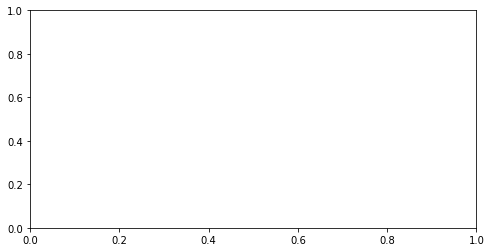

In [ ]:
show_distribution('FLAG_EMP_PHONE')

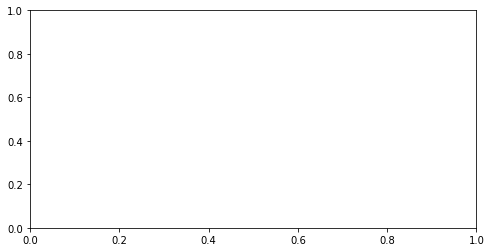

In [ ]:
show_distribution('REGION_RATING_CLIENT_W_CITY')

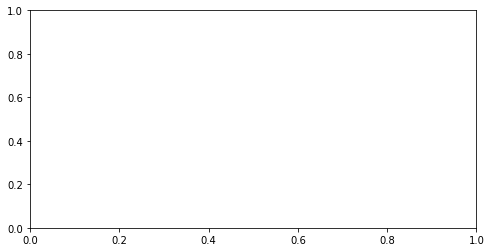

In [ ]:
show_distribution('EXT_SOURCE_2')

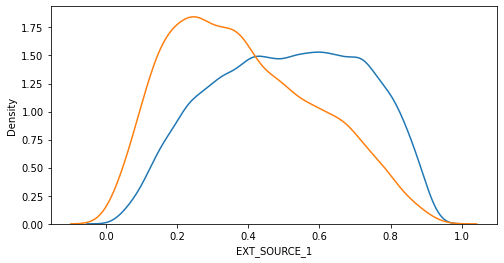

In [ ]:
show_distribution('EXT_SOURCE_1')

## Model training

In [ ]:
feature_cols = corr_data.index

all_df = pd.concat([train, test]).reset_index(drop=True)[feature_cols]
all_df

,DAYS_BIRTH,FLAG_EMP_PHONE,CNT_CHILDREN,DAYS_REGISTRATION,CNT_FAM_MEMBERS,DAYS_ID_PUBLISH,AMT_CREDIT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_EMPLOYED
0,-9233,1,0,-333.0,2.0,-522,755190.0,NaN,0.372591,NaN,NaN,-878
1,-20148,0,0,-4469.0,2.0,-3436,585000.0,1.0,0.449567,0.553165,NaN,365243
2,-18496,1,0,-3640.0,2.0,-2050,334152.0,NaN,0.569503,NaN,NaN,-523
3,-24177,0,0,-4950.0,1.0,-3951,152820.0,0.0,0.105235,0.767523,NaN,365243
4,-10685,1,0,-5101.0,2.0,-3226,271066.5,4.0,0.202490,0.669057,0.342344,-697
...,...,...,...,...,...,...,...,...,...,...,...,...
232697,-11430,1,0,-9772.0,2.0,-2705,1288350.0,1.0,0.018172,0.307737,0.263678,-792
232698,-17181,1,0,-5125.0,2.0,-668,273636.0,0.0,0.668578,0.434733,NaN,-839
232699,-14515,1,0,-7225.0,1.0,-4795,291384.0,0.0,0.574151,NaN,0.510226,-722
232700,-16914,1,1,-5233.0,3.0,-231,746280.0,3.0,0.226714,NaN,0.353295,-8756


In [ ]:
all_df = all_df.fillna(all_df.mean())

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

def show_hist(pred):
    plt.figure(figsize=(8,4))
    plt.hist(pred[np.where(y_valid == 0)], bins=200, alpha=0.85, label='neg class')
    plt.hist(pred[np.where(y_valid == 1)], bins=200, alpha=0.85, label='pos class')
    plt.legend()
    plt.show()

AUC: 0.7372702509497562


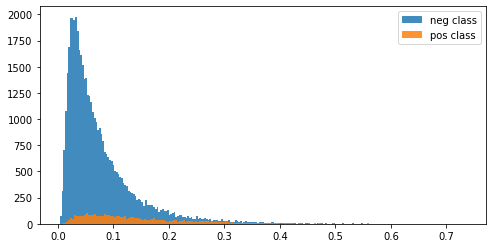

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)
    
y_pred = model.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)
    
print(f'AUC: {score}')
show_hist(y_pred)

## Submit prediction

In [ ]:
submission['TARGET'] = model.predict_proba(X_test)[:, 1]
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2021_Summer/competition2/output/submission.csv')
submission.head()

,TARGET
SK_ID_CURR,
171202,0.041794
171203,0.165598
171204,0.155770
171205,0.203831
171206,0.167983
